# Heart Disease Predictor 

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [9]:
data = pd.read_csv('heart_2020_cleaned.csv')

In [10]:
print(data.head())
print(data.info())

  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1       

## Data Cleaning

In [11]:
data.isnull().values.any()

False

In [12]:
data.duplicated().sum()

18078

In [15]:
data = data.drop_duplicates()
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


## Understanding the data

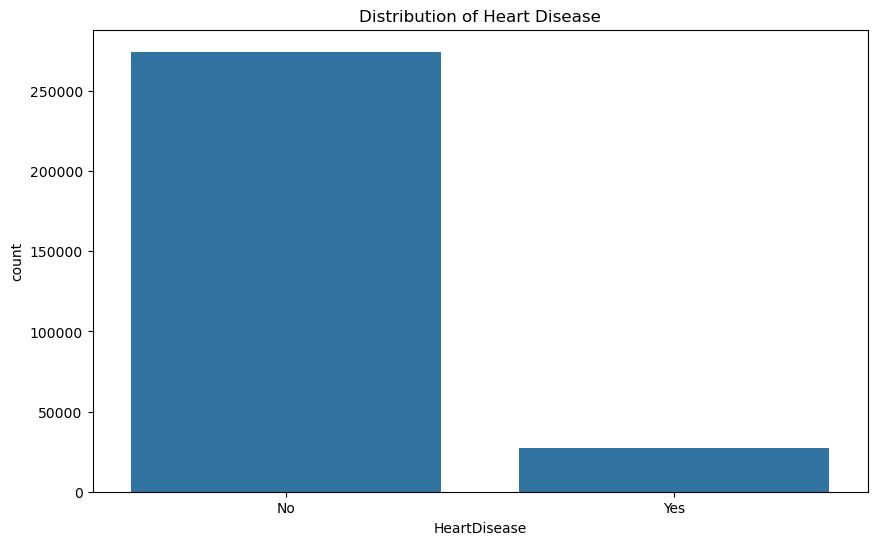

In [17]:
## Plotting the distribution of heart disease
plt.figure(figsize=(10,6))
sns.countplot(x='HeartDisease', data=data)
plt.title('Distribution of Heart Disease')
plt.show()

**Explanation for the graph:** 
1. There is a significant imblance between two classes: 
    - the 'No' category (people without heart disease) has a much higher count (around 275,000)
    - The 'Yes' category (people with heart disease) has a lower count, with approximately 30,000 individuals 
2. This means that this could potentially bias the model towards predicting the majority class(No heart disease)
3. We might need to emply oversampling, undersampling or use weight classes to give a more accurate reading 

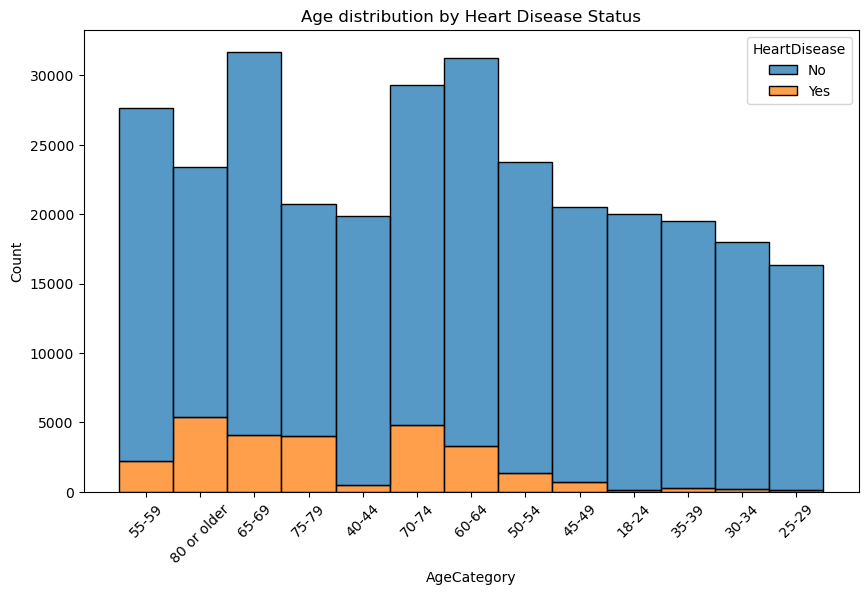

In [19]:
## Age distribution for patients with and without heart disease 
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='AgeCategory', hue='HeartDisease', multiple='stack')
plt.title('Age distribution by Heart Disease Status')
plt.xticks(rotation=45)
plt.show()

This histogram shows the age distribution of individuals with and without heart disease for different age categories. 

1. Blue represents individuals without heart disease 
2. Orange represents individuals with heart disease 
3. Trends: 
    - There is a clear trend showing that heart disease becomes more prevalent as age increases 
    - The age groups 55-59, 60-64, 65-69 have the highest counts of heart disease cases 
    - Heart disease is rare in younger age groups

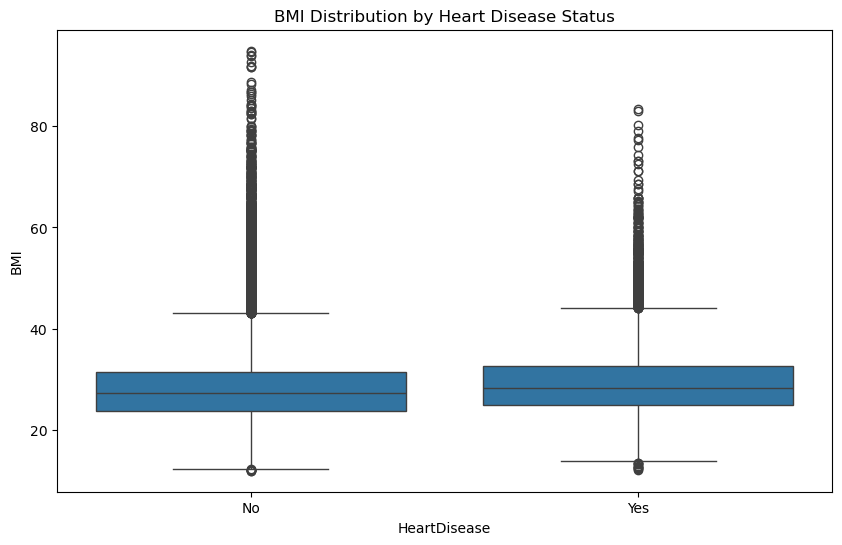

In [20]:
## BMI distribution of heart disease / no heart disease 
plt.figure(figsize=(10,6))
sns.boxplot(x='HeartDisease', y='BMI', data=data)
plt.title('BMI Distribution by Heart Disease Status')
plt.show()

**Box Plot Components:** 
1. The box represents the interquartile range (IQR), which contains the middle 50% of data 
2. The horizontal line inside the box is the median BMI for each group 
3. The whiskers show the rest of the distribution, except for points that are considered outliers 
4. Dots beyond the whiskers represent outliers 

**Key Observations:** 
1. The median BMI for those with heart disease appears to be slightly higher than those without 
2. The box for Yes group seems slightly larger, suggesting a little more variablity in BMI for people with heart disease. 
3. Both groups have numerous outliers, which means that there are very high BMI values in both categories

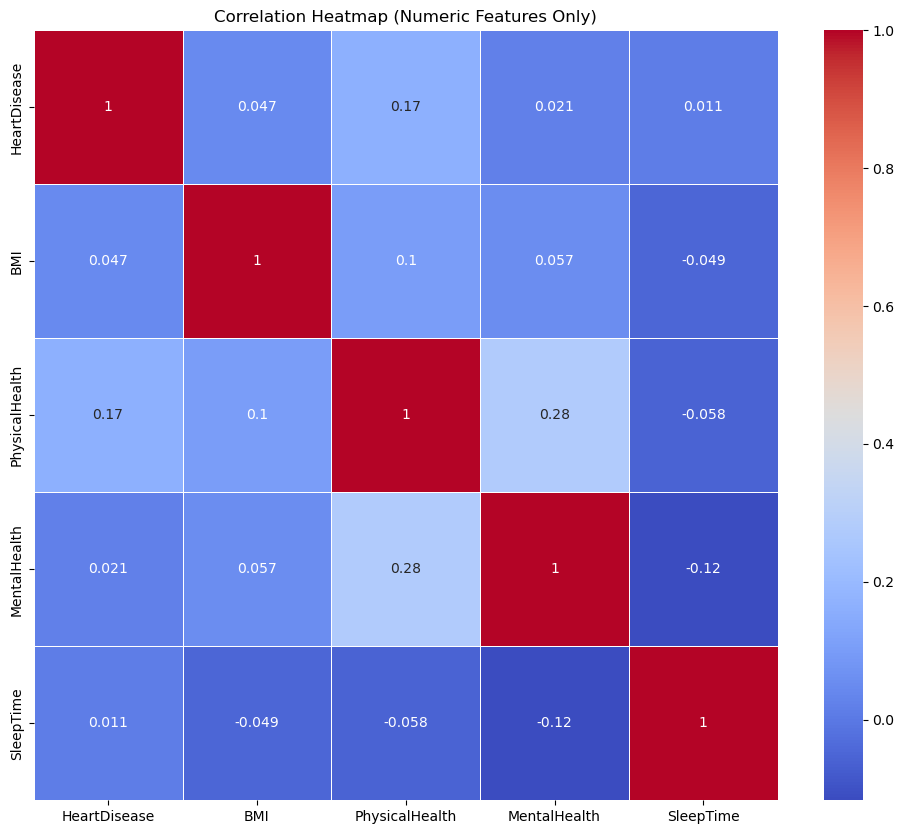

In [33]:
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

This heatmap shows the correlations between HeartDisease, BMI, PhysicalHealth, MentalHealth and SleepTime 

- Red indicates positive correlation (closer to 1)
- Blue indicates negative correlation (closer to -1)
- White or light colors indicate weak or no correlation (closer to 0)

**Key Trends:** 

1. HeartDisease: 
    - Strongest correlation with PhysicalHealth(0.17)
    - Weak positive correlation with BMI (0.047)
    - Weak positive correlation with Mental Health (0.021)
    - Very weak correlation with SleepTime(0.011)
2. BMI: 
    - Weak positive correlations with PhysicalHealth(0.1) and MentalHealth(0.057)
    - Weak negative correlation with SleepTime(-0.049)
3. PhysicalHealth: 
    - Moderative positive correlation with MentalHealth(0.28)
    - Weak negative correlation with SleepTime(-0.058)
4. MentalHealth: 
    - Weak negative correlation with SleepTime(-0.12)

The weak correlations suggest that there is no single numeric feature that is a strong predictor for heart disease on it's own. 

## Preprocessing the data for the model

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [97]:
# Load the data
data = pd.read_csv('heart_2020_cleaned.csv')
print("Original data shape:", data.shape)

# Identify numeric and categorical columns
numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
categorical_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 
                        'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 
                        'Asthma', 'KidneyDisease', 'SkinCancer']

# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

Original data shape: (319795, 18)


In [98]:
# Prepare features and target
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease'].map({'Yes': 1, 'No': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BMI', 'PhysicalHealth',
                                                   'MentalHealth',
                                                   'SleepTime']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Smoking', 'AlcoholDrinking',
                                                   'Stroke', 'DiffWalking',
                                                   'Sex', 'AgeCategory', 'Race',
                                                   'Diabetic',
                                                   'PhysicalActivity',
                                                   'GenHealth', 'Asthma',
                                                   'KidneyDisease',
                                                   'SkinCancer'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [99]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9138

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959



### Conclusion: 
<br> 
1. Overall Accuracy: The model achieves an accuracy of **91.38%** <br>
2. The dataset is highly imbalanced, which affects model performance, especially for the category for heart disease <br>
<br>
**Class 0:**  <br>
3. The model correctly predicts no heart disease **92%** of the time <br>
4. The model identifies **99%** of actual no heart disease cases <br>
5. F1 score is **0.95** which shows a strong performance for class 0 <br>

**Class 1:** 
<br>
4. The model correctly predicts heart disease **54%** of the time<br> 
5. The model identifies **10%** of actual  heart disease cases <br>
6. F1 score is **0.17** which shows a a weaker comparative performance <br>

The model is heavily biased towards no heart disease, primarily because of the dataset 
